# Cheat sheet on causality
Python notebook with NoobQuant dev conda environment. Uses R magic within R installation in the same environment.

For R (magic) commands, make sure of the following:
 - .libPaths() contains only one, correct library path
 - R packages *dagitty* and *R.utils* installed to dev conda environment via R installation: ```install.packages(pckgname, dependencies = T)```
 - Due to output problems in Windows with rpy2 and R magic, extention [RWinOut](https://github.com/vitorcurtis/RWinOut) is used to bypass the problems. This extension is a third-party external load each time Notebook is run.


Useful links:
 - https://cran.r-project.org/web/packages/dagitty/vignettes/dagitty4semusers.html
 - http://www.dagitty.net/manual-3.x.pdf
 - https://cran.r-project.org/web/packages/dagitty/dagitty.pdf
 - https://nickch-k.github.io/introcausality/Cheat%20Sheets/Causal_Diagrams_Cheat_Sheet.pdf


## Setting up notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
from statsmodels.stats.moment_helpers import corr2cov

import rpy2
%load_ext rpy2.ipython

In [2]:
#%%R
#install.packages("R.utils")
#install.packages("dagitty")

Load RWinOut. This downloads *RWinOut.py* to command folder.

In [3]:
#!curl -O "https://raw.githubusercontent.com/vitorcurtis/RWinOut/master/RWinOut.py

In [4]:
%load_ext RWinOut

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


R imports

In [5]:
%%R
#.libPaths(.libPaths()[2])
print(.libPaths())

[1] "D:/Anaconda3/envs/temp/lib/R/library"


In [6]:
%%R 
library(dagitty)

## Concepts

### d-separation

Pearl (2009) Definition 1.2.3: <i> A path p is said to be d-separated (or blocked) by a set of nodes Z if and only if 1) p contains a pipe i->m->j or a fork i<-m->j such that the middle node m is in Z, or 2) p contains a collider i -> m \<\- j such that the middle node is not in Z and such that no decendant of m is in Z. A set Z is said to d-separate X from Y if and only if Z blocks every path from a node in X to a node Y.</i>
    
Pearl (2009) Theorem 1.2.4: <i>If sets X and Y are d-separated by Z in a DAG G, then X is independent of Y conditional on Z in every distribution compatible with G. Conversely, if X and Y are not d-separated by Z in a DAG G, then X and Y are dependent conditional on Z in at least one distribution compatible with G.</i>

### stability/faithfulnes

Pearl (2009) Definition 2.4.1. Quite technical. Essentially: if distribution generated by causal model M is stable, it means that this distribution is such where independencies are borne due to structural independencies, not by numerical peculiarities.

Moneta (2004b, p.4) Causal Faithfulness Assumption: <i>If corr(A, B|C) is zero then A and B are d-separated by C on the graph G</i>. This implies directly that A and B are independent given C. Here we **assume** that faithfulness holds. Not sure if it does though! [Here (p.10)](http://mlg.eng.cam.ac.uk/zoubin/SALD/Intro-Causal.pdf) it is argued that faithfulness is not that hefty an assumption, though.

### Inferred causation

Pearl (2009) Causality, page 47. Imagine that observations taken over four variables {a, b, c, d} reveal two independencies: "a is independent of b" and "d is independent of {a, b} given c". These two conditions alone are enough to establish an unambigious causal result c -> d without any assumptions about the presence or absence of latent variables. More generally, **in some cases it is possible to infer causal relations based solely on observed data without additional qualitative causal assumptions**.

This DAG is consistent with data. It is also minimal, i.e. entails only the observed independencies and none other.

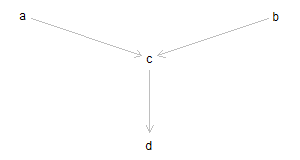

a _||_ b
a _||_ d | c
b _||_ d | c


In [8]:
%%R -h 160 -w 300
g1 = dagitty( 'dag {
    a [pos="0,0"]
    b [pos="2,0"]
    c [pos="1,1"]
    d [pos="1,3"]

    a -> c <- b
    d <- c
}')
plot(g1)
print(impliedConditionalIndependencies(g1))

DAG below is not consitent with data: a and b become independent of d without conditioning on c.

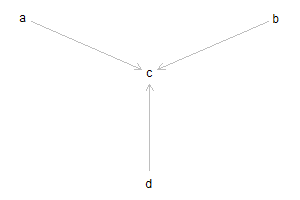

a _||_ b
a _||_ d
b _||_ d


In [11]:
%%R -h 200 -w 300
g1 = dagitty( 'dag {
    a [pos="0,0"]
    b [pos="2,0"]
    c [pos="1,1"]
    d [pos="1,3"]

    c <- b
    d -> c
    c <- a
}')
plot(g1)
print(impliedConditionalIndependencies(g1))

Below DAG "out-mimicks" the very first one. I don't get this, to me it seems this DAG produces less independencies than the first one => this is exactly the reason: it fits a broader set of distributions than those of the first DAG. For example, below DAG acccommodates distributions with arbitrary relations between a and b.

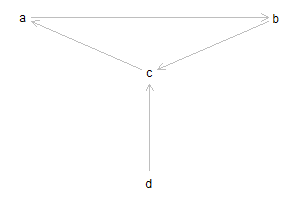

a _||_ d | b, c


In [13]:
%%R -h 200 -w 300
g1 = dagitty( 'dag {
    a [pos="0,0"]
    b [pos="2,0"]
    c [pos="1,1"]
    d [pos="1,3"]

    c <- b
    d -> c
    c -> a -> b
}')
plot(g1)
print(impliedConditionalIndependencies(g1))

### Possible biases
- Collider bias
- Post-treatment bias

### Three rules of do-calculus

From *Book of Why* page 234-235.

**Rule 1**
Observing variable $W$ that is irrelevant to $Y$ (possibly conditionally o other set of variables $Z$) does not change probability distribution of $Y$.

\begin{align}
P(Y | do(X), \ Z, \ W) & = P(Y | do(X), \ Z)
\end{align}

**Rule 2**
If a set of variables $Z$ blocks all back-door paths from $X$ to $Y$, the conditional on $Z$, $do(X)$ is equivalent to $see(X)$.

\begin{align}
P(Y | do(X), \ Z) & = P(Y | X, \ Z)
\end{align}

**Rule 3**
If ther are no causal paths from $X$ to $Y$ (i.e. no paths from $X$ to $Y$ with only forward-directed arrows) then $do(X)$ has no effect on the probability distribution of $Y$. 

\begin{align}
P(Y | do(X)) & = P(Y)
\end{align}

## Examples

### Example from *The Book of Why* Figure 7.4

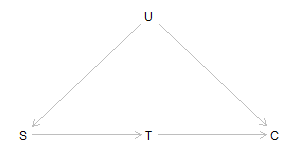

In [14]:
%%R -h 150 -w 300
options(repr.plot.width=3, repr.plot.height=1)

# In this DAG U is latent
g1 = dagitty( 'dag {
    U [latent, pos="1,0"]
    S [exposure, pos="0,1"]
    T [pos="1,1"]
    C [outcome, pos="2,1"]        

    S <- U -> C
    S -> T -> C
}')

# In this DAG U is not latent
g2 = dagitty( 'dag {
    U [pos="1,0"]
    S [exposure, pos="0,1"]
    T [pos="1,1"]
    C [outcome, pos="2,1"]        

    S <- U -> C
    S -> T -> C
}')
plot(g1)

In case of graph *g1*, front-door criterion may be used. Below is the equicalent result due to do-calculus:

$
\begin{align*}
P(c \ | \ do(s)) & = \sum_t P(c \ | \ do(s), \ t) \ P(t \ | \ do(s)) \quad & \text{Laf of total probability} \\
& = \sum_t P(c \ | \ do(s), \ do(t)) \ P(t \ | \ do(s)) \quad & do(s) \text{ blocks bdp T<-S<-U->C ==> Rule 2} \\
& = \sum_t P(c \ | \ do(s), \ do(t)) \ P(t \ | \ s) \quad & \text{ no bdp b/w S and T ==> Rule 2} \\
& = \sum_t P(c \ | \ do(t)) \ P(t \ | \ s) \quad & \text{no causal path b/w S and C after controlling } do(t) \text{ ==> Rule 3} \\
& = \sum_{s'} \sum_t P(c \ | \ do(t), \ s') \ P(s' \ | \ do(t)) \ P(t \ | \ s) \quad & \text{Laf of total probability} \\
& = \sum_{s'} \sum_t P(c \ | \ t, \ s') \ P(s' \ | \ do(t)) \ P(t \ | \ s) \quad & s' \text{ blocks bdp T<-S<-U->C ==> Rule 2} \\
& = \sum_{s'} \sum_t P(c \ | \ t, \ s') \ P(s') \ P(t \ | \ s) \quad & \text{no causal path T->S ==> Rule 3} \\
\end{align*}
$

#### Using dagitty on previous example
How can we obtain the result from dagitty here?

In [15]:
%%R
print(paths(g1))

$paths
[1] "S -> T -> C" "S <- U -> C"

$open
[1] TRUE TRUE



In [16]:
%%R
# Returns empty, as U is latent and there are no adjustment sets
print(adjustmentSets(g1, type = c("minimal","canonical", "all"), effect = c("total", "direct")))
print("---")
# Returns U
print(adjustmentSets(g2, type = c("minimal","canonical", "all"), effect = c("total", "direct")))

[1] "---"
 { U }


In [17]:
%%R
print(impliedConditionalIndependencies(g1))
print("---")
print(impliedConditionalIndependencies(g2))

[1] "---"
C _||_ S | T, U
T _||_ U | S


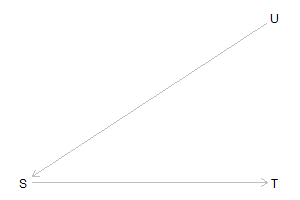

[1] "T" "S" "U"
[1] "S"


In [18]:
%%R -h 200 -w 300
plot(ancestorGraph(g1, "T"))
print(ancestors(g1, "T"))
print(parents(g1, "T"))

In [19]:
%%R
print(descendants(g1, "T"))
print(children(g1, "T"))

[1] "T" "C"
[1] "C"


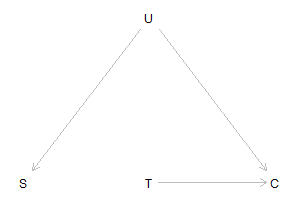

In [20]:
%%R -h 200 -w 300
# Removes every first edge on a proper causal path from input graph
plot(backDoorGraph(g1))

In [21]:
%%R
print(dconnected(g1, "S", "C"))
print(dconnected(g1, "S", "C", c("T")))
print(dconnected(g1, "S", "C", c("U", "T")))
print("---")
print(dconnected(g2, "S", "C"))
print(dconnected(g2, "S", "C", c("T")))
print(dconnected(g2, "S", "C", c("U", "T")))

[1] TRUE
[1] TRUE
[1] FALSE
[1] "---"
[1] TRUE
[1] TRUE
[1] FALSE


### Example on closing back doors

Found in video [Causality: Closing Back Doors](https://www.youtube.com/watch?v=IajzIKW518M) by Nick Huntington-Klein.

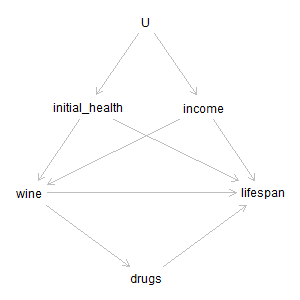

In [22]:
%%R -h 300 -w 300
ex2 = dagitty( 'dag {
    wine [exposure, pos="0,2"]
    lifespan [outcome, pos="4,2"]
    initial_health [pos="1,1"]
    income [pos="3,1"]
    drugs [pos="2,3"]
    U [latent, pos="2,0"]

    wine -> lifespan
    wine -> drugs -> lifespan
    initial_health <- U -> income
    wine <- initial_health -> lifespan
    wine <- income -> lifespan
}')
plot(ex2)

In [23]:
%%R
print(paths(ex2))

$paths
[1] "wine -> drugs -> lifespan"                        
[2] "wine -> lifespan"                                 
[3] "wine <- income -> lifespan"                       
[4] "wine <- income <- U -> initial_health -> lifespan"
[5] "wine <- initial_health -> lifespan"               
[6] "wine <- initial_health <- U -> income -> lifespan"

$open
[1] TRUE TRUE TRUE TRUE TRUE TRUE



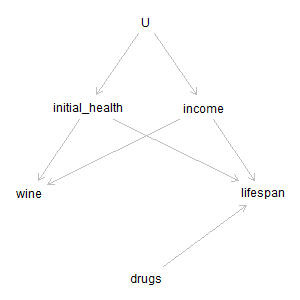

 { income, initial_health }


In [24]:
%%R -h 300 -w 300
print(adjustmentSets(ex2))
plot(backDoorGraph(ex2))

In [25]:
%%R
print(impliedConditionalIndependencies(ex2))

drugs _||_ income | wine
drugs _||_ initial_health | wine


### Example from Cooley & LeRoy (1985): *Atheoretical macroeconomics*
Page 11 in pdf, page 293 in journal.

Consider model

$
\begin{align*}
m & = \epsilon_1 \\
z & = \tau m + \epsilon_2 \\
y & = \gamma m + \beta z + \epsilon_3 \\
\end{align*}
$

where $Corr(\epsilon_3, \epsilon_1) = Corr(\epsilon_3, \epsilon_2) = 0$ but $Corr(\epsilon_1, \epsilon_2) \neq 0$. That is, only $\epsilon_3$ is *exogenous* with respect to *y*, i.e. (as stated in text) "uncorrelated with the unobserved determinants of *y*". 

Authors write: <i>"\[B]ecause of the assumed correlation between $\epsilon_1$ and $\epsilon_2$, the effect of an intervention in m (or, equivalently, $\epsilon_1$) on z, cet. par., is ambigious. But note that in this case, the effect of m on y, cet. par., does not depend on whether the correlation between $\epsilon_1$ and $\epsilon_2$ comes about because $\epsilon_1$ causes $\epsilon_2$, $\epsilon_2$ causes $\epsilon_1$, or both respond to a third variable. This is so because in this context the 'cet. par.' proviso ensures that z is held constant as m is varied... -  Thus even though m is not exogenous as defined above - so that, accordingly, the effect of an intervention in m is on z is not well-defined - still the effect of m on y, cet. par., is unambigious."<i>

That is, although *e3* is only "exogenous" variable, we can still estimate the causal effect of nonendogenous variables (*e1*).


Minimal sufficient adjustment set for estimating the *direct effect* of *m* is *{z}*.

Notice that
 - *z* does not satisfy back-door criterion (Pearl (2009) Definition 3.3.1) as *z* is a decendant of *e1*.
 - if *effect=total*, *adjustmentSets()* yields empty list, ie. total and direct effects are not the same in this graph! See [page 9 in this manual](http://www.dagitty.net/manual-3.x.pdf) for more. Actually total effects cannot be estimated in this setting due to an indermediate variable (*z*). 

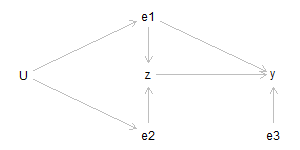

 { z }


In [26]:
%%R -h 150 -w 300 -o g2
# DAG assuming there is a latent variable causing both e1 and e2
options(repr.plot.width=3, repr.plot.height=1)
g2 = dagitty( 'dag {
    U  [latent pos="0,1"]
    z  [pos="1,1"]
    e1 [exposure pos="1,0"]
    e2 [latent pos="1,2"]
    e3 [latent pos="2,2"]
    y  [outcome pos="2,1"]

    e1 <- U -> e2
    e1 -> z <- e2
    e1 -> y <- z
    e3 -> y
}')
plot(g2)
adjustmentSets(g2, exposure="e1", outcome="y", effect="direct")

Simulation exercise:

In [27]:
# True parameters
n = 10000
tau = 0.3
gamma = -0.2
beta = 0.5
corr = 0.7 # for e1 and e2
means = [0, 0, 0] # for e1-3
stds = [1, 1, 1] # for e1-3

# Simulate data assuming e's are normally distributed
df = pd.DataFrame()
cov = corr2cov([[1, corr], [corr, 1]], stds[:2])
rawvars = np.random.multivariate_normal(mean=means[:2], cov=cov, size=n)
df["e1"] = rawvars[:, 0]
df["e2"] = rawvars[:, 1]
df["e3"] = np.random.normal(loc=means[2], scale=stds[2], size=n)
df["m"] = df["e1"]
df["z"] = tau*df["m"] + df["e2"]
df["y"] = gamma*df["m"] + beta*df["z"] + df["e3"]

Adjusting both for *m* and *z* in regression yields unbiased estimates

In [28]:
result = sm.ols(formula="y ~ m + z", data=df).fit()
print(result.summary())
print("-"*30)
print("True coefficients: m coef {:.4f}, z coef {:.4f}".format(gamma, beta))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     1098.
Date:                Mon, 10 Aug 2020   Prob (F-statistic):               0.00
Time:                        17:15:10   Log-Likelihood:                -14243.
No. Observations:               10000   AIC:                         2.849e+04
Df Residuals:                    9997   BIC:                         2.851e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0014      0.010     -0.135      0.8

Adjusting only either for *m* or *z* yields very biased estimates! These slopes are visible in the simple pairs plots.

In [29]:
result = sm.ols(formula="y ~ m", data=df).fit()
print(result.params)
print("-"*30)
result = sm.ols(formula="y ~ z", data=df).fit()
print(result.params)

Intercept   -0.005899
m            0.299544
dtype: float64
------------------------------
Intercept   -0.003134
z            0.367919
dtype: float64


Regression as pictures: from simple pairs plot we see how *y ~ m* and *y ~ z* yield positive slopes. However, when we run *y ~ m + z* we essetially regress *y* on *m* for every stratum of *z*; illustrative plot of this is shown in plot below, where we clearly see a negative slope per every stratum.

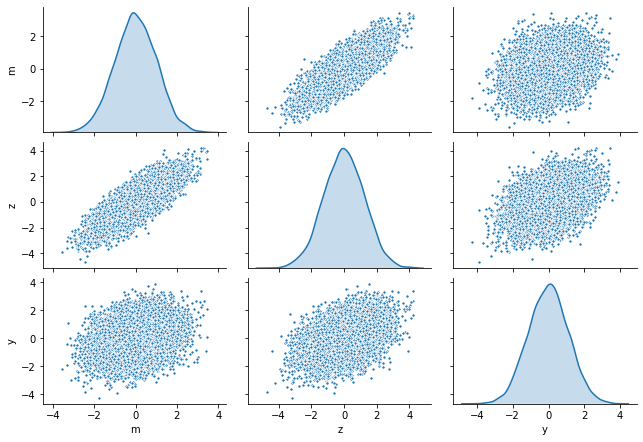

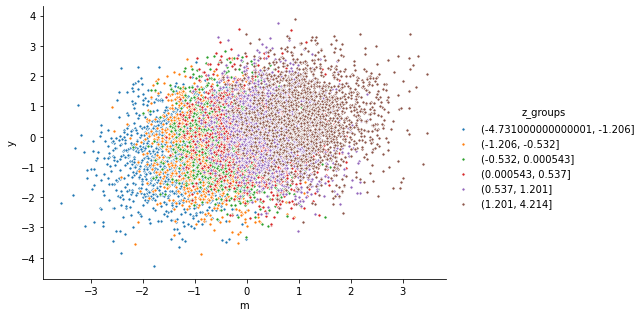

In [30]:
sns.pairplot(df[["m", "z", "y"]], diag_kind='kde', height=2, aspect=1.5, plot_kws={'s':10})
gg = df[["m", "y", "z"]].copy()
gg["z_groups"] = pd.qcut(df["z"], 6)
_ = sns.pairplot(x_vars="m", y_vars="y", hue="z_groups", data=gg, height=4.27, aspect=1.5, plot_kws={'s':10})